In [143]:
import numpy as np
import cv2
import seaborn
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [144]:
img=cv2.imread('sharapova1.jpg')
img.shape

(555, 700, 3)

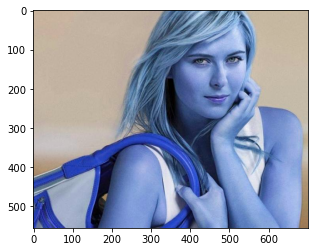

In [145]:
plt.imshow(img)

In [146]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray.shape

(555, 700)

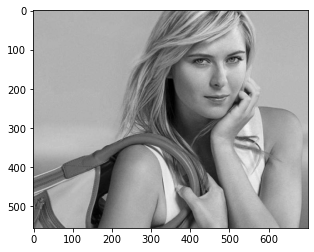

In [147]:
plt.imshow(gray,cmap='gray')

In [148]:
gray

array([[175, 175, 175, ..., 176, 175, 174],
       [175, 175, 175, ..., 177, 175, 174],
       [175, 175, 175, ..., 177, 176, 174],
       ...,
       [ 84,  87,  88, ..., 113, 113, 113],
       [ 88,  89,  90, ..., 113, 113, 113],
       [ 93,  91,  91, ..., 112, 112, 112]], dtype=uint8)

In [149]:
eye_cascade=cv2.CascadeClassifier('haarcascade_eye.xml')
face_cascade=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces=face_cascade.detectMultiScale(gray,1.3,5)
faces

array([[352,  38, 233, 233]], dtype=int32)

In [150]:
(x,y,w,h)=faces[0]
x,y,w,h

(352, 38, 233, 233)

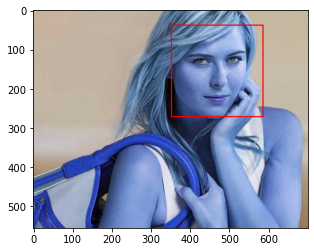

In [151]:
face_img=cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

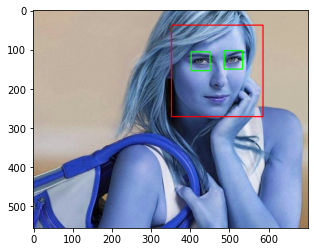

In [152]:
#cv2.destroyAllwindows()
for (x,y,w,h) in faces:
    face_img=cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray=gray[y:y+h,x:x+w]
    roi_color=face_img[y:y+h,x:x+w]
    eyes=eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.figure()
plt.imshow(face_img,cmap='gray')
plt.show()

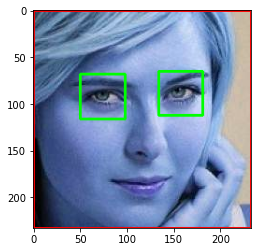

In [153]:
plt.imshow(roi_color,cmap='gray')

In [154]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
        

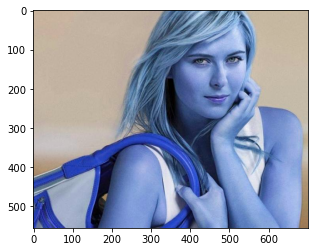

In [155]:
original_image=cv2.imread('sharapova1.jpg')
plt.imshow(original_image)

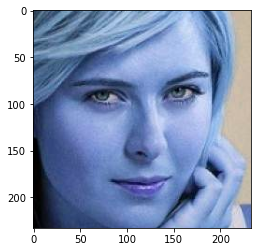

In [156]:
cropped_image=get_cropped_image_if_2_eyes('sharapova1.jpg')
plt.imshow(cropped_image)

In [157]:
cropped_image1=get_cropped_image_if_2_eyes('sharapova2.JPG')
cropped_image1

In [158]:
path_to_data='./dataset/'
path_to_cr_data='./dataset/cropped/'

In [159]:
import os
img_dirs=[]
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [160]:
img_dirs

['./dataset/lionel_messi',
 './dataset/maria_sharapova',
 './dataset/roger_federer',
 './dataset/serena_williams',
 './dataset/virat_kohli']

In [161]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [202]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1
    

# Wavelet Transform technique

In [189]:
import numpy as np
import pywt
import cv2

In [190]:
def w2d(img,mode='haar',level=1):
    imArray=img
    imArray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    imArray=np.float32(imArray)
    imArray/=255
    coeffs=pywt.wavedec2(imArray,mode,level=level)
    coeffs_H=list(coeffs)
    coeffs_H[0]*=0
    imArray_H=pywt.waverec2(coeffs_H,mode)
    imArray_H*=255
    imArray_H=np.uint8(imArray_H)
    return imArray_H


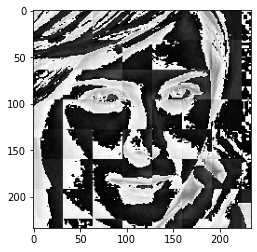

In [191]:
im_har=w2d(cropped_image,'db1',5)
plt.imshow(im_har,cmap='gray')

In [192]:
class_dict={}
count=0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name]=count
    count+=1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [193]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

error: OpenCV(4.5.3) /tmp/pip-req-build-afu9cjzs/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [194]:
len(X[0])

4096

In [195]:
X[0]

array([[  4],
       [  3],
       [  5],
       ...,
       [103],
       [ 10],
       [ 67]], dtype=uint8)

In [196]:
y

[0]

In [197]:
celebrity_file_names_dict

{'lionel_messi': ['./dataset/cropped/lionel_messi/lionel_messi1.png',
  './dataset/cropped/lionel_messi/lionel_messi2.png',
  './dataset/cropped/lionel_messi/lionel_messi3.png',
  './dataset/cropped/lionel_messi/lionel_messi4.png',
  './dataset/cropped/lionel_messi/lionel_messi5.png',
  './dataset/cropped/lionel_messi/lionel_messi6.png',
  './dataset/cropped/lionel_messi/lionel_messi7.png',
  './dataset/cropped/lionel_messi/lionel_messi8.png',
  './dataset/cropped/lionel_messi/lionel_messi9.png',
  './dataset/cropped/lionel_messi/lionel_messi10.png',
  './dataset/cropped/lionel_messi/lionel_messi11.png',
  './dataset/cropped/lionel_messi/lionel_messi12.png',
  './dataset/cropped/lionel_messi/lionel_messi13.png',
  './dataset/cropped/lionel_messi/lionel_messi14.png',
  './dataset/cropped/lionel_messi/lionel_messi15.png',
  './dataset/cropped/lionel_messi/lionel_messi16.png',
  './dataset/cropped/lionel_messi/lionel_messi17.png',
  './dataset/cropped/lionel_messi/lionel_messi18.png',
  '

# Training Model

In [198]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
 
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [199]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(1, 4096)

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

ValueError: With n_samples=1, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [201]:
print(classification_report(y_test, pipe.predict(X_test)))

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [176]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [177]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [178]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

model  best_score  \
0                  svm    0.666667   
1        random_forest    0.533333   
2  logistic_regression    0.740741   

                                    best_params  
0        {'svc__C': 1, 'svc__kernel': 'linear'}  
1  {'randomforestclassifier__n_estimators': 10}  
2                  {'logisticregression__C': 1}

In [179]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [180]:
best_estimators['svm'].score(X_test,y_test)

0.8

In [181]:
best_estimators['random_forest'].score(X_test,y_test)

0.8444444444444444

In [182]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8666666666666667

In [183]:
best_clf = best_estimators['svm']

In [184]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 9,  1,  0,  0,  0],
       [ 0,  8,  0,  0,  2],
       [ 0,  0,  1,  2,  0],
       [ 1,  2,  0,  6,  0],
       [ 0,  1,  0,  0, 12]])

Text(69.0, 0.5, 'Truth')

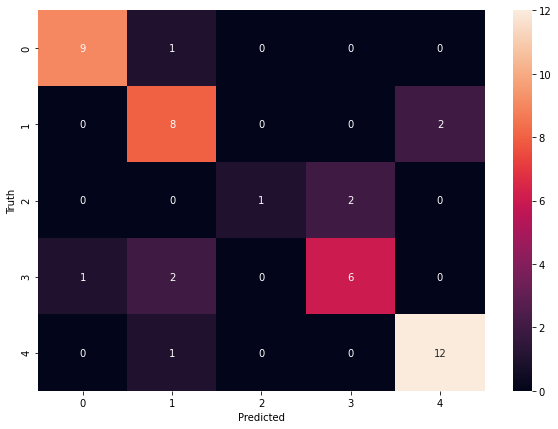

In [185]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [186]:
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

# Trained model save

In [187]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

You should consider upgrading via the '/home/amol/anaconda3/bin/python -m pip install --upgrade pip' command.


['saved_model.pkl']

# Save directory of class

In [188]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))